**Experiment 3 ( use Fine-tuned roBERTa Vs roBERTa with different optimizers )**

In [ ]:
%pip install -q transformers datasets seqeval torchmetrics imbalanced-learn
!pip install lion-pytorch
!pip install pytorch-optimizer
from IPython.display import clear_output
clear_output()


In [7]:
import time
import numpy as np
import torch
from transformers import (
    RobertaTokenizerFast,
    RobertaForTokenClassification,
    TrainingArguments,
    Trainer,
    get_linear_schedule_with_warmup,
    DataCollatorForTokenClassification
)
from datasets import load_dataset
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [8]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(24)

**Dataset (with class balancing)**

In [9]:
labels = ["O", "B-AC", "B-LF", "I-LF"]
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", add_prefix_space=True)
data_collator = DataCollatorForTokenClassification(tokenizer)

def tokenize_and_align(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )


    ner_tags = examples["ner_tags"]

    labels = []
    for i, label_seq in enumerate(ner_tags):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[label_seq[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

print("Loading dataset...")
raw = load_dataset("surrey-nlp/PLOD-CW-25")

# first tokenize without removing columns to analyse class distribution
temp_ds = raw.map(tokenize_and_align, batched=True)

# analyse class distribution before balancing
def get_class_distribution(dataset):
    all_labels = [label for seq in dataset["labels"] for label in seq if label != -100]
    return Counter([id2label[l] for l in all_labels])

print("\nOriginal Class Distribution:")
print(f"Train: {get_class_distribution(temp_ds['train'])}")
print(f"Val: {get_class_distribution(temp_ds['validation'])}")
print(f"Test: {get_class_distribution(temp_ds['test'])}")

# now process with column removal
tokenized_ds = raw.map(tokenize_and_align, batched=True, remove_columns=raw["train"].column_names)
train_ds, val_ds, test_ds = tokenized_ds["train"], tokenized_ds["validation"], tokenized_ds["test"]

# class balancing by oversampling
from torch.utils.data import WeightedRandomSampler

def create_sampler(dataset):
    labels = [label for seq in dataset["labels"] for label in seq if label != -100]
    class_counts = torch.bincount(torch.tensor(labels))
    class_weights = 1. / class_counts
    sample_weights = torch.tensor([class_weights[label] for label in labels])
    return WeightedRandomSampler(sample_weights, len(sample_weights))

train_sampler = create_sampler(train_ds)


Loading dataset...

Original Class Distribution:
Train: Counter({'O': 59261, 'I-LF': 9237, 'B-AC': 6392, 'B-LF': 3820})
Val: Counter({'O': 4323, 'I-LF': 724, 'B-AC': 493, 'B-LF': 305})
Test: Counter({'O': 7464, 'I-LF': 1168, 'B-AC': 768, 'B-LF': 466})


Map: 100%|██████████| 150/150 [00:00<00:00, 6316.85 examples/s]


In [25]:
# Save a sample of test inputs to use in the web app
import json

# Get first 100 test samples
test_texts = raw['test']['tokens'][:100]

with open("test_samples.json", "w") as f:
    json.dump(test_texts, f)

In [26]:
# Save the aligned test labels to JSON
test_labels = test_ds["labels"][:100]
with open("test_labels.json", "w") as f:
    json.dump(test_labels, f)

**metrics**

In [10]:
from transformers import TrainerCallback
label_list = labels

def compute_metrics(p):
    preds, labs = p
    preds = np.argmax(preds, axis=2)

    true_preds = [
        [label_list[p] for p, l in zip(pred, lab) if l != -100]
        for pred, lab in zip(preds, labs)
    ]
    true_labs = [
        [label_list[l] for p, l in zip(pred, lab) if l != -100]
        for pred, lab in zip(preds, labs)
    ]

    return {
        "f1":        f1_score(true_labs, true_preds),
        "precision": precision_score(true_labs, true_preds),
        "recall":    recall_score(true_labs, true_preds),
    }

class TrainEvalF1Callback(TrainerCallback):
    def __init__(self):
        self.trainer = None

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.trainer is None:
            return

        # evaluate on the *training* split
        train_metrics = self.trainer.evaluate(train_ds)
        train_f1      = train_metrics["eval_f1"]


        val_f1 = state.log_history[-1]["eval_f1"]


        self.trainer.log({"train_f1": train_f1})

        # console print
        print(f"epoch {int(state.epoch)} | train F1 {train_f1:.4f} | val F1 {val_f1:.4f}")


**custom LAMB Optimizer**

In [11]:
class Lamb(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9,0.999), eps=1e-6, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('LAMB does not support sparse gradients')

                state = self.state[p]
                if not state:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1

                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                update = exp_avg / denom

                if group['weight_decay'] != 0:
                    update.add_(p.data, alpha=group['weight_decay'])

                w_norm = torch.norm(p.data)
                u_norm = torch.norm(update)
                trust = torch.where(
                    (w_norm>0) & (u_norm>0),
                    w_norm / u_norm,
                    torch.ones_like(w_norm)
                ).clamp(0,10)

                p.data.add_(update, alpha=-group['lr']*trust)
        return loss

**training with class weights**

In [12]:
from typing import Dict, List, Optional
from torch import nn

class WeightedTrainer(Trainer):

    def __init__(self, class_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels  = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits

        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(
            logits.view(-1, model.config.num_labels),
            labels.view(-1)
        )
        return (loss, outputs) if return_outputs else loss


def plot_training_history(trainer, optimizer_name: str) -> None:

    history = trainer.state.log_history

    metrics = {
        'loss':      {'label': 'Train Loss',      'color': 'blue'},
        'eval_loss': {'label': 'Validation Loss', 'color': 'orange'},
        'train_f1':  {'label': 'Train F1',        'color': 'green'},
        'eval_f1':   {'label': 'Val F1',          'color': 'red'},
    }

    plt.figure(figsize=(18, 4))

    for i, (metric, cfg) in enumerate(metrics.items(), 1):
        plt.subplot(1, 4, i)
        values = [x[metric] for x in history if metric in x]
        plt.plot(values, marker='o', label=cfg['label'], color=cfg['color'])
        plt.title(f"{optimizer_name} {cfg['label']}")
        plt.xlabel('Epoch')
        plt.ylabel(cfg['label'])
        plt.grid(alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

# main training function

def train_model(
    model,
    train_data,
    val_data,
    optimizer_name="adam",
    epochs=3,
    lr=2e-5,
    bs=16,
    warmup_ratio=0.1,
):
# optmizers
    if optimizer_name.lower() == "adam":
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    elif optimizer_name.lower() == "lamb":
        from pytorch_optimizer import Lamb
        optimizer = Lamb(model.parameters(), lr=lr, betas=(0.9, 0.999),
                         eps=1e-6, weight_decay=0.01)
    elif optimizer_name.lower() == "lion":
        from lion_pytorch import Lion
        optimizer = Lion(model.parameters(), lr=lr, betas=(0.9, 0.99),
                         weight_decay=0.01)
    else:
        raise ValueError("Supported optimizers: adam, lamb, lion")


    total_steps  = len(train_data) // bs * epochs
    warmup_steps = int(total_steps * warmup_ratio)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    label_counts = Counter([l for seq in train_data["labels"]
                            for l in seq if l != -100])
    total = sum(label_counts.values())
    class_weights = torch.tensor(
        [1.0 - (label_counts.get(i, 0) / total) for i in range(len(labels))],
        device=device
    )


    args = TrainingArguments(
        output_dir              = f"./results_{optimizer_name}",
        per_device_train_batch_size = bs,
        per_device_eval_batch_size  = bs,
        num_train_epochs         = epochs,
        evaluation_strategy      = "epoch",
        save_strategy            = "epoch",
        logging_strategy         = "epoch",
        logging_steps            = 50,
        load_best_model_at_end   = True,
        metric_for_best_model    = "f1",
        greater_is_better        = True,
        report_to                = "none",
        fp16                     = torch.cuda.is_available(),
    )

    trainer = WeightedTrainer(
        model           = model,
        args            = args,
        train_dataset   = train_data,
        eval_dataset    = val_data,
        compute_metrics = compute_metrics,
        tokenizer       = tokenizer,
        data_collator   = data_collator,
        optimizers      = (optimizer, scheduler),
        class_weights   = class_weights,
        callbacks       = [TrainEvalF1Callback()],
    )


    print(f"\nTraining with {optimizer_name.upper()}...")
    print("Class weights:", {id2label[i]: f"{w:.4f}" for i, w in enumerate(class_weights)})

    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time

    plot_training_history(trainer, optimizer_name.upper())
    return trainer, training_time


**Instantiate STANDARD trainer for error analysis**

In [13]:
# baseline (unfined tuned) model
baseline_model = RobertaForTokenClassification.from_pretrained(
    "roberta-base",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
).to(device)

# evaluation
baseline_args = TrainingArguments(
    output_dir="./baseline_eval",
    per_device_eval_batch_size=16,
    do_train=False,
    do_eval=True,
    report_to="none",
    fp16=torch.cuda.is_available(),
)


std_trainer = Trainer(
    model=baseline_model,
    args=baseline_args,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

print("std_trainer is ready for baseline error analysis (no training).")

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


std_trainer is ready for baseline error analysis (no training).


**baseline (no fine tune)**

In [14]:
def evaluate_standard_roberta(eval_dataset, split_name="test"):
    print(f"\nEvaluating *untrained* RoBERTa on {split_name} split…\n")

    model = RobertaForTokenClassification.from_pretrained(
        "roberta-base",
        num_labels=len(label_list),
        id2label=id2label,
        label2id=label2id,
    ).to(device)

    eval_args = TrainingArguments(
        output_dir=f"./baseline_{split_name}_eval",
        per_device_eval_batch_size=16,
        do_train=False,
        do_eval=True,
        report_to="none",
        fp16=torch.cuda.is_available(),
    )

    trainer = Trainer(
        model=model,
        args=eval_args,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )

    results = trainer.evaluate(eval_dataset=eval_dataset)

    loss      = results.get("eval_loss",    None)
    f1        = results.get("eval_f1",     0.0)
    precision = results.get("eval_precision", 0.0)
    recall    = results.get("eval_recall",  0.0)

    if loss is not None:
        print(f"  Loss      : {loss:.4f}")
    print(f"  F1        : {f1:.4f}")
    print(f"  Precision : {precision:.4f}")
    print(f"  Recall    : {recall:.4f}\n")

    return results
train_baseline_results = evaluate_standard_roberta(train_ds, split_name="train")





Evaluating *untrained* RoBERTa on train split…



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Loss      : 1.3229
  F1        : 0.0650
  Precision : 0.0429
  Recall    : 0.1341



**Baseline F1 train and val**

In [15]:
# F1 on TRAIN split
train_metrics = std_trainer.evaluate(train_ds)
print(f"Train F1 = {train_metrics['eval_f1']:.4f}")

# F1 on VALIDATION split
val_metrics = std_trainer.evaluate(val_ds)
print(f"Val   F1 = {val_metrics['eval_f1']:.4f}")


Train F1 = 0.0729
Val   F1 = 0.0730


**Plot Baseline Loss on Train vs Validation **


Evaluating *untrained* RoBERTa on train split…



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Loss      : 1.2931
  F1        : 0.0740
  Precision : 0.0452
  Recall    : 0.2035


Evaluating *untrained* RoBERTa on validation split…



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Loss      : 1.3705
  F1        : 0.1143
  Precision : 0.0711
  Recall    : 0.2920



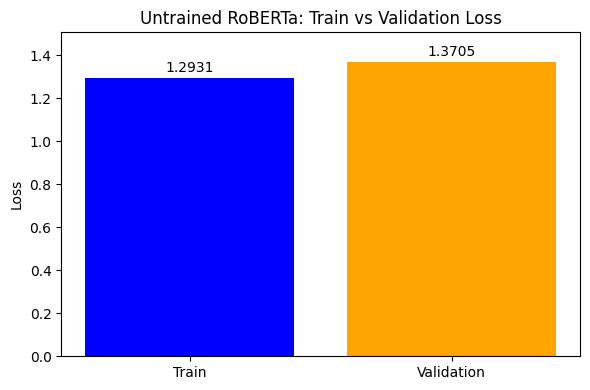

In [16]:
train_res = evaluate_standard_roberta(train_ds, split_name="train")
val_res   = evaluate_standard_roberta(val_ds,   split_name="validation")

train_loss = train_res.get("eval_loss", None)
val_loss   = val_res.get("eval_loss",   None)

if train_loss is None or val_loss is None:
    print("Could not find 'eval_loss' in the results dicts.")
else:
    # for plotting
    splits = ["Train", "Validation"]
    losses = [train_loss, val_loss]

    # plot
    plt.figure(figsize=(6,4))
    bars = plt.bar(splits, losses, color=["blue","orange"])
    plt.title("Untrained RoBERTa: Train vs Validation Loss")
    plt.ylabel("Loss")
    plt.ylim(0, max(losses) * 1.1)

    for bar, val in zip(bars, losses):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            val + 0.01 * max(losses),
            f"{val:.4f}",
            ha="center", va="bottom"
        )

    plt.tight_layout()
    plt.show()


**Standard baseline error analysis**


TRAIN SPLIT — Sequence level report

              precision    recall  f1-score   support

          AC     0.0531    0.4467    0.0949      6392
          LF     0.0009    0.0034    0.0014      3820

   micro avg     0.0419    0.2808    0.0729     10212
   macro avg     0.0270    0.2250    0.0482     10212
weighted avg     0.0336    0.2808    0.0600     10212



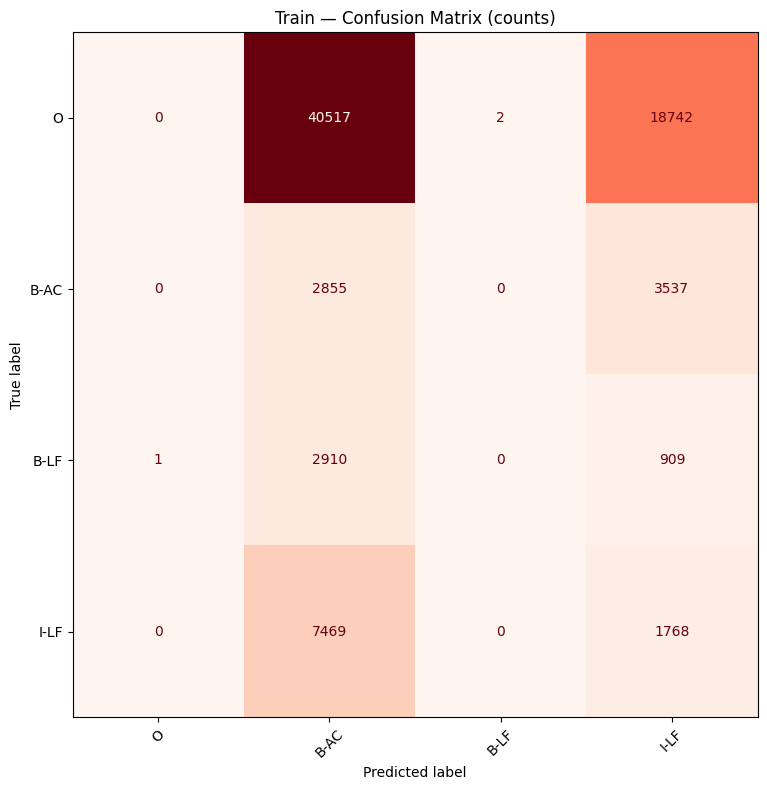

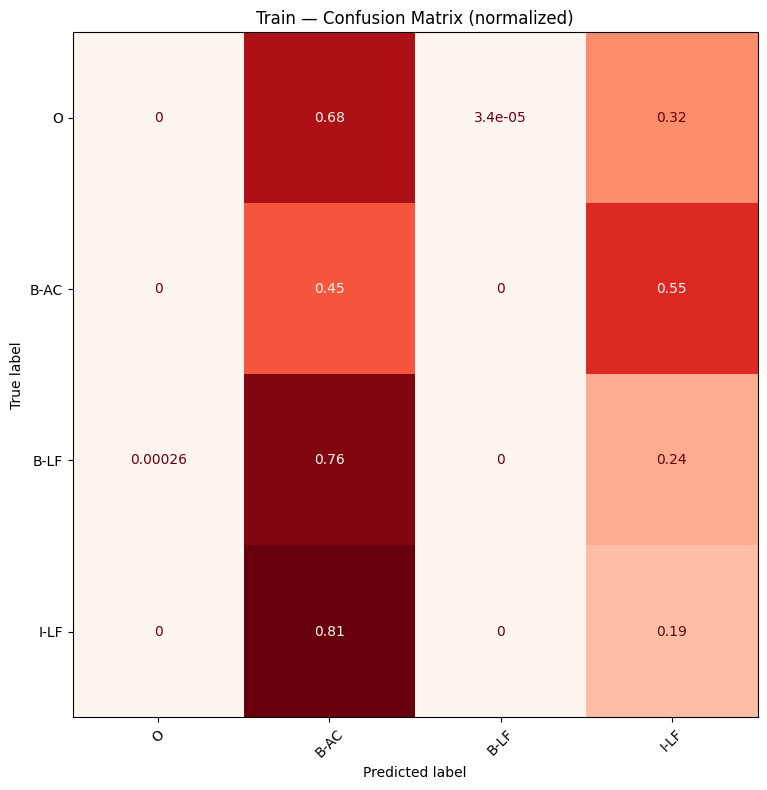


VALIDATION SPLIT — Sequence level report



/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

          AC     0.0540    0.4381    0.0962       493
          LF     0.0000    0.0000    0.0000       305

   micro avg     0.0422    0.2707    0.0730       798
   macro avg     0.0270    0.2191    0.0481       798
weighted avg     0.0334    0.2707    0.0594       798



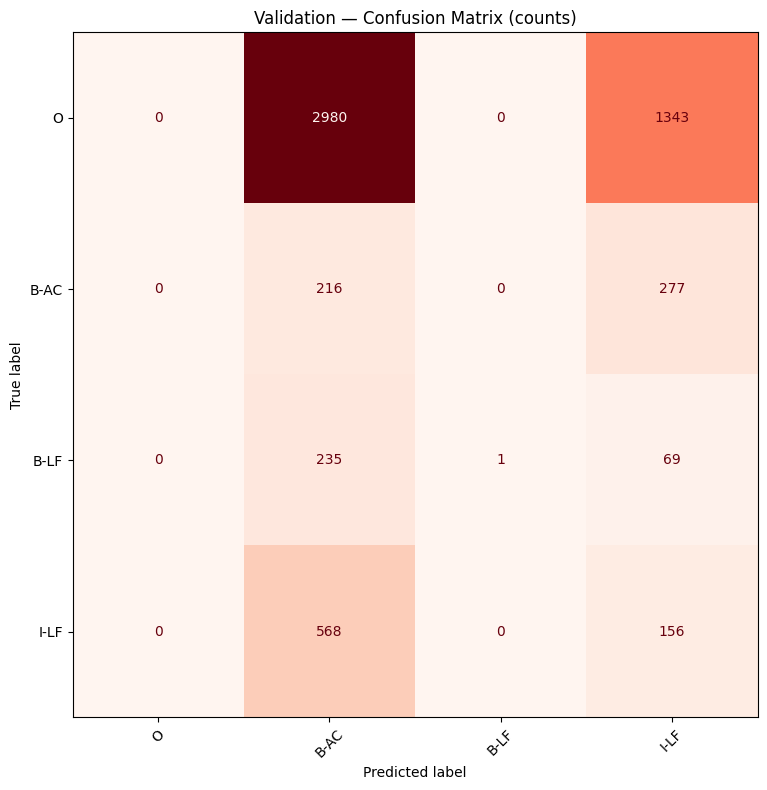

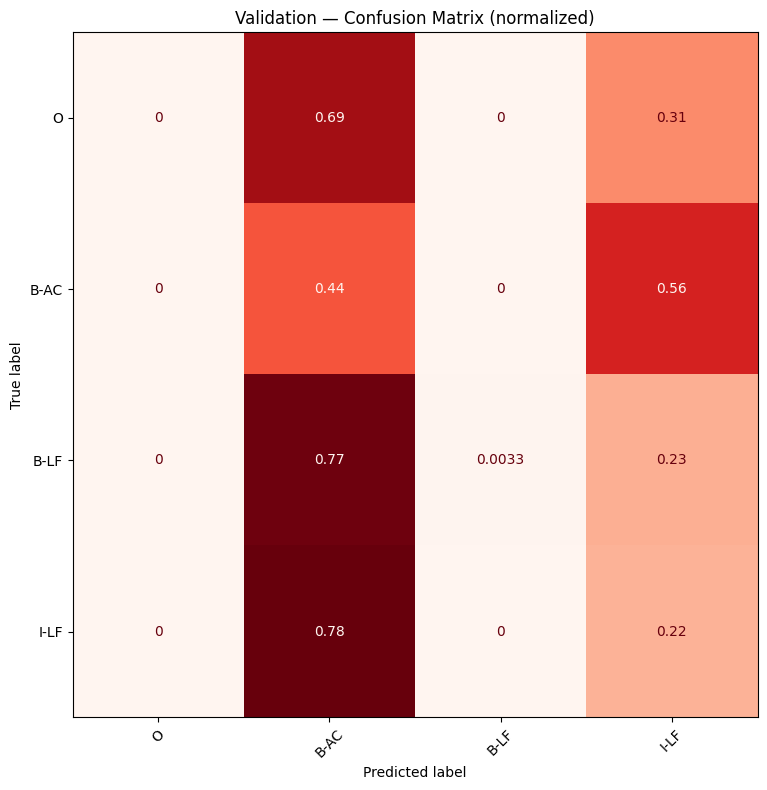

In [17]:

from seqeval.metrics import classification_report as seq_classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def analyse_split_seqeval(split_name, dataset):
    print(f"\n{split_name.upper()} SPLIT — Sequence level report\n")

    # predictions
    out       = std_trainer.predict(dataset)
    logits    = out.predictions
    label_ids = out.label_ids
    preds     = np.argmax(logits, axis=2)

    true_labels = []
    pred_labels = []
    for true_seq, pred_seq in zip(label_ids, preds):
        tl, pl = [], []
        for t, p in zip(true_seq, pred_seq):
            if t == -100:
                continue
            tl.append(id2label[int(t)])
            pl.append(id2label[int(p)])
        true_labels.append(tl)
        pred_labels.append(pl)

    #report
    print(seq_classification_report(true_labels, pred_labels, digits=4))

    flat_true = [lbl for seq in true_labels for lbl in seq]
    flat_pred = [lbl for seq in pred_labels for lbl in seq]

    # confusion matrix/ count
    cm = confusion_matrix(flat_true, flat_pred, labels=label_list)
    disp = ConfusionMatrixDisplay(cm, display_labels=label_list)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Reds, colorbar=False)
    ax.set_title(f"{split_name} — Confusion Matrix (counts)")
    plt.tight_layout()
    plt.show()

    # confusion matrix/ normalised
    cmn = confusion_matrix(flat_true, flat_pred, labels=label_list, normalize="true")
    dispn = ConfusionMatrixDisplay(cmn, display_labels=label_list)
    fig, ax = plt.subplots(figsize=(10, 8))
    dispn.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Reds, colorbar=False)
    ax.set_title(f"{split_name} — Confusion Matrix (normalized)")
    plt.tight_layout()
    plt.show()

# run for both splits
analyse_split_seqeval("Train",      train_ds)
analyse_split_seqeval("Validation", val_ds)





**Plot Baseline Train vs Validation Metrics**

/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


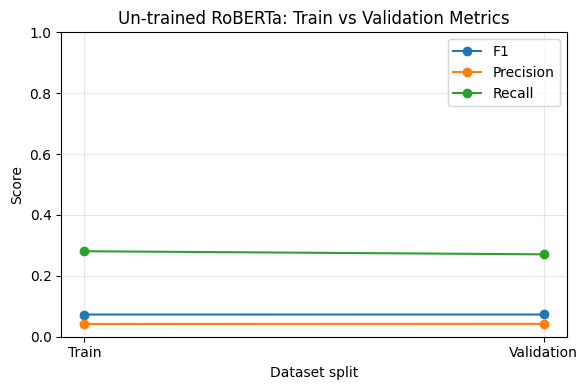

In [18]:
# compute metrics for each split
metrics = {}
for split_name, ds in [("Train", train_ds), ("Validation", val_ds)]:
    out       = std_trainer.predict(ds)
    logits    = out.predictions
    label_ids = out.label_ids
    m         = compute_metrics((logits, label_ids))
    metrics[split_name] = {"f1": m["f1"], "precision": m["precision"], "recall": m["recall"]}

# prepare for plotting
splits = ["Train", "Validation"]
f1_vals = [metrics[s]["f1"] for s in splits]
prec_vals = [metrics[s]["precision"] for s in splits]
rec_vals = [metrics[s]["recall"] for s in splits]

# plot
plt.figure(figsize=(6,4))
plt.plot(splits, f1_vals, marker="o", label="F1")
plt.plot(splits, prec_vals, marker="o", label="Precision")
plt.plot(splits, rec_vals, marker="o", label="Recall")
plt.title("Un‑trained RoBERTa: Train vs Validation Metrics")
plt.xlabel("Dataset split")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



**fine tuned RoBerta with 3 optmiser( adam, lamb, lion)**


 training with ADAM


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/t3/spmbj0b13fn7ykhmtf9d6tm80000gn/T/ipykernel_30297/1686310696.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.969800,0.597859,0.003341,0.032028,0.001763
2,0.478400,0.439273,0.515240,0.551632,0.483353
3,0.436700,0.402179,0.613181,0.618744,0.607716


epoch 1 | train F1 0.0033 | val F1 0.0033


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 2 | train F1 0.5152 | val F1 0.5152


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 3 | train F1 0.6132 | val F1 0.6132


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ADAM → Test F1: 0.6335  (training time 236.0s)

 training with LAMB


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/t3/spmbj0b13fn7ykhmtf9d6tm80000gn/T/ipykernel_30297/1686310696.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,1.400500,1.379972,0.037441,0.023685,0.089307
2,1.349900,1.345638,0.033965,0.022190,0.072366
3,1.335700,1.334363,0.032243,0.021363,0.065707


epoch 1 | train F1 0.0374 | val F1 0.0374


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 2 | train F1 0.0340 | val F1 0.0340


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 3 | train F1 0.0322 | val F1 0.0322


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LAMB → Test F1: 0.0289  (training time 294.7s)

 training with LION


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/t3/spmbj0b13fn7ykhmtf9d6tm80000gn/T/ipykernel_30297/1686310696.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.376000,0.215754,0.801642,0.743347,0.869859
2,0.186200,0.177745,0.844117,0.772698,0.930082
3,0.173000,0.152129,0.862411,0.802462,0.932041


epoch 1 | train F1 0.8016 | val F1 0.8016


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 2 | train F1 0.8441 | val F1 0.8441


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 3 | train F1 0.8624 | val F1 0.8624


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LION → Test F1: 0.8551  (training time 229.4s)


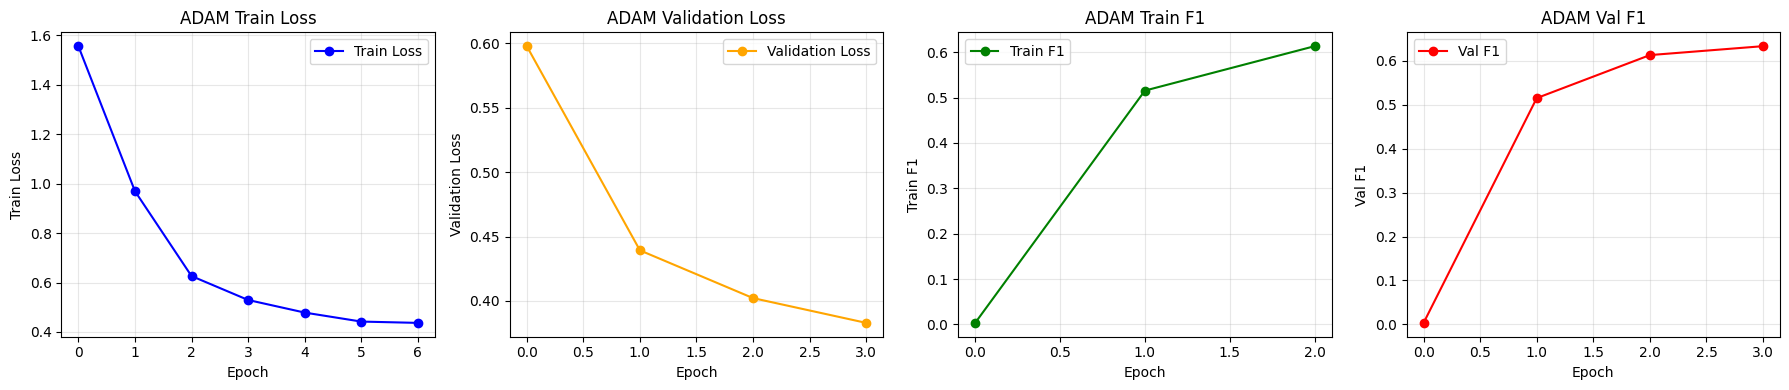

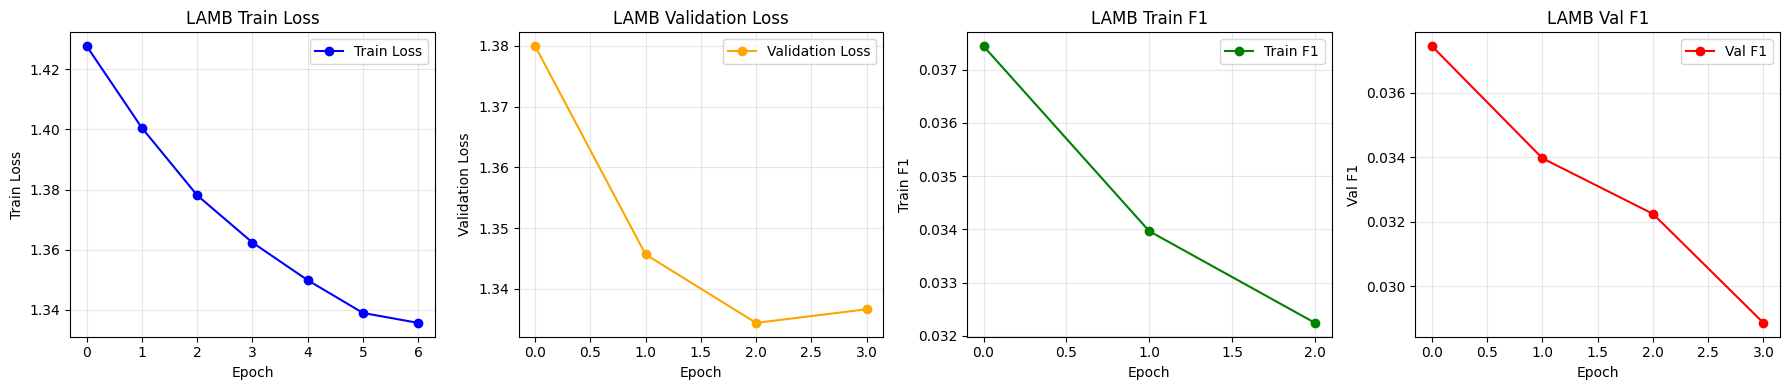

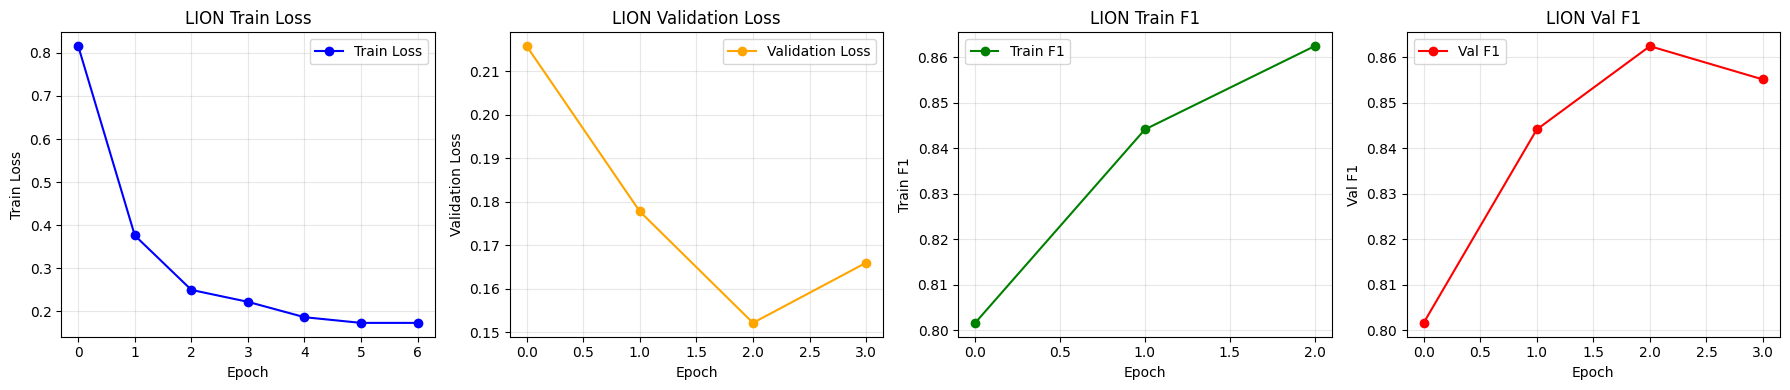

In [19]:
from lion_pytorch import Lion
from pytorch_optimizer import Lamb
import time
import matplotlib.pyplot as plt

def compare_optimizers(
    train_data, val_data, test_data,
    optimizers=("adam", "lamb", "lion"),
    epochs=3, lr=5e-6, bs=16
):
    results, training_times, trainers = {}, {}, {}

    base_args = dict(
        output_dir                   ="./results",
        per_device_train_batch_size  = bs,
        per_device_eval_batch_size   = bs,
        num_train_epochs             = epochs,
        learning_rate                = lr,
        save_strategy                ="epoch",
        load_best_model_at_end       = True,
        metric_for_best_model        ="f1",
        greater_is_better            = True,
        logging_steps                = 50,
        report_to                    ="none",
        disable_tqdm                 = False,
        seed                         = 42,
    )

    try:
        args = TrainingArguments(
            evaluation_strategy="epoch",
            logging_strategy   ="epoch",
            **base_args
        )
    except TypeError:
        args = TrainingArguments(
            eval_strategy="epoch",
            **base_args
        )

    for opt in optimizers:
        print(f"\n training with {opt.upper()}")

        model = RobertaForTokenClassification.from_pretrained(
            "roberta-base",
            num_labels=len(label2id),
            id2label=id2label,
            label2id=label2id,
        ).to(device)

        if opt == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
        elif opt == "lamb":
            optimizer = Lamb(model.parameters(), lr=lr, betas=(0.9, 0.999),
                             eps=1e-6, weight_decay=0.01)
        elif opt == "lion":
            optimizer = Lion(model.parameters(), lr=lr, betas=(0.9, 0.99),
                             weight_decay=0.01)
        else:
            raise ValueError("Choose among: adam, lamb, lion")

        f1_cb = TrainEvalF1Callback()
        trainer = Trainer(
            model           = model,
            args            = args,
            train_dataset   = train_data,
            eval_dataset    = val_data,
            compute_metrics = compute_metrics,
            tokenizer       = tokenizer,
            data_collator   = data_collator,
            optimizers      = (optimizer, None),
            callbacks       = [f1_cb],
        )
        f1_cb.trainer = trainer
        trainers[opt] = trainer

        start = time.time()
        trainer.train()
        training_times[opt] = time.time() - start

        test_metrics = trainer.evaluate(test_data)
        results[opt] = test_metrics
        print(f"{opt.upper()} → Test F1: {test_metrics['eval_f1']:.4f}  "
              f"(training time {training_times[opt]:.1f}s)")

    return results, training_times, trainers

# run the comparison
results, training_times, trainers = compare_optimizers(train_ds, val_ds, test_ds)
# Save the LION-trained model and tokenizer
best_trainer = trainers['lion']
best_trainer.save_model("ner_roberta_lion_model")
tokenizer.save_pretrained("ner_roberta_lion_model")

import json

with open("ner_roberta_lion_model/label2id.json", "w") as f:
    json.dump(label2id, f)
with open("ner_roberta_lion_model/id2label.json", "w") as f:
    json.dump(id2label, f)

# evaluation: plot train vs val loss & F1 for each optimizer
for opt, tr in trainers.items():
    plot_training_history(tr, opt.upper())



**result comparsion of F1 TRAIN and VAL for all optmizers**

In [20]:
import pandas as pd

def final_f1(tr):
    log = pd.DataFrame(tr.state.log_history)


    train_f1 = log["train_f1"].dropna().iloc[-1] if "train_f1" in log.columns else None
    val_f1   = log["eval_f1"]. dropna().iloc[-1] if "eval_f1"  in log.columns else None

    if train_f1 is None:
        train_f1 = tr.evaluate(tr.train_dataset)["eval_f1"]
    if val_f1 is None:
        val_f1   = tr.evaluate(tr.eval_dataset )["eval_f1"]

    return train_f1, val_f1

#  multiple trainers from compare_optimizers

if "trainers" in globals() and isinstance(trainers, dict):
    summary = []
    for name, tr in trainers.items():
        t_f1, v_f1 = final_f1(tr)
        summary.append({"optimizer": name.upper(),
                        "train_f1": f"{t_f1:.4f}",
                        "val_f1":   f"{v_f1:.4f}"})
    display(pd.DataFrame(summary).set_index("optimizer"))

# single trainer variant

elif "trainer" in globals():
    t_f1, v_f1 = final_f1(trainer)
    print(f"Final Train F1 = {t_f1:.4f}")
    print(f"Final Val   F1 = {v_f1:.4f}")

else:
    print("No trainer objects found in the workspace.")

,train_f1,val_f1
optimizer,,
ADAM,0.6132,0.6335
LAMB,0.0322,0.0289
LION,0.8624,0.8551


**Sequence Level Test Set reports for optimizers**


In [21]:
from seqeval.metrics import classification_report

for opt_name, tr in trainers.items():
    print(f"\n {opt_name.upper()} – TEST SET")

    pred_out = tr.predict(test_ds)
    logits = pred_out.predictions
    label_ids = pred_out.label_ids
    preds = np.argmax(logits, axis=2)

    # format predictions and labels as sequences
    y_true, y_pred = [], []
    for seq_t, seq_p in zip(label_ids, preds):
        true_seq, pred_seq = [], []
        for t, p in zip(seq_t, seq_p):
            if t == -100:
                continue
            true_seq.append(id2label[int(t)])
            pred_seq.append(id2label[int(p)])
        y_true.append(true_seq)
        y_pred.append(pred_seq)

    # print classification report using seqeval
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))




 ADAM – TEST SET


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report:
              precision    recall  f1-score   support

          AC     0.8106    0.6354    0.7124       768
          LF     0.4739    0.6052    0.5316       466

   micro avg     0.6433    0.6240    0.6335      1234
   macro avg     0.6423    0.6203    0.6220      1234
weighted avg     0.6835    0.6240    0.6441      1234


 LAMB – TEST SET
Classification Report:
              precision    recall  f1-score   support

          AC     0.0170    0.0365    0.0232       768
          LF     0.0203    0.1009    0.0338       466

   micro avg     0.0189    0.0608    0.0289      1234
   macro avg     0.0186    0.0687    0.0285      1234
weighted avg     0.0182    0.0608    0.0272      1234


 LION – TEST SET
Classification Report:
              precision    recall  f1-score   support

          AC     0.8349    0.9349    0.8821       768
          LF     0.7464    0.8906    0.8121       466

   micro avg     0.8001    0.9182    0.8551      1234
   macro avg     0.7906

**fine tune Roberta with optmizers error analysis**


ADAM – confusion matrix



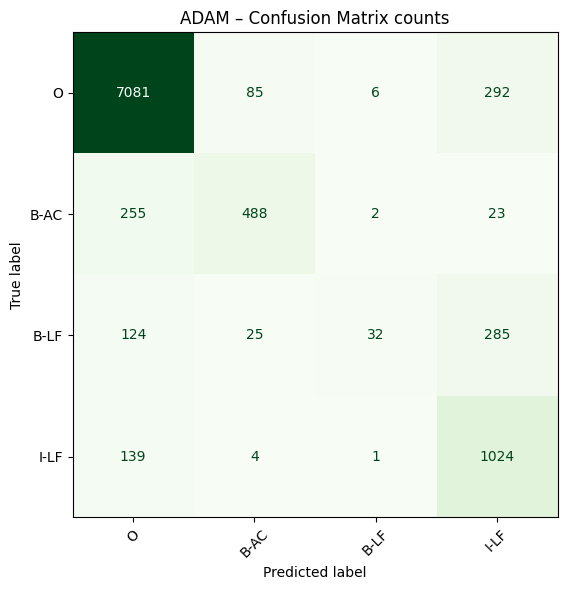

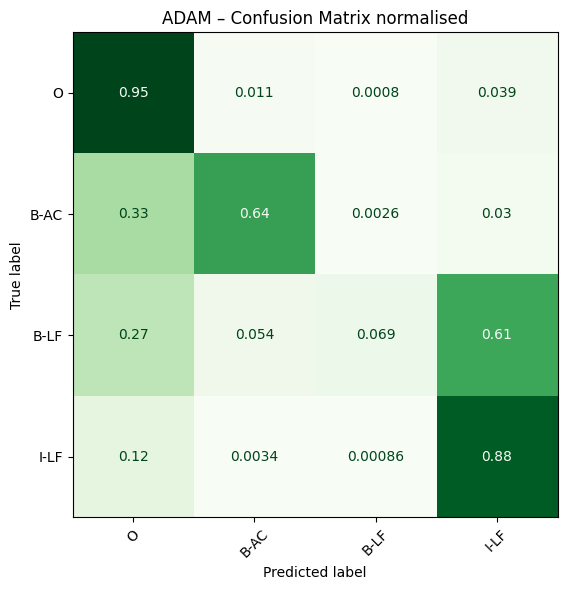


LAMB – confusion matrix



/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


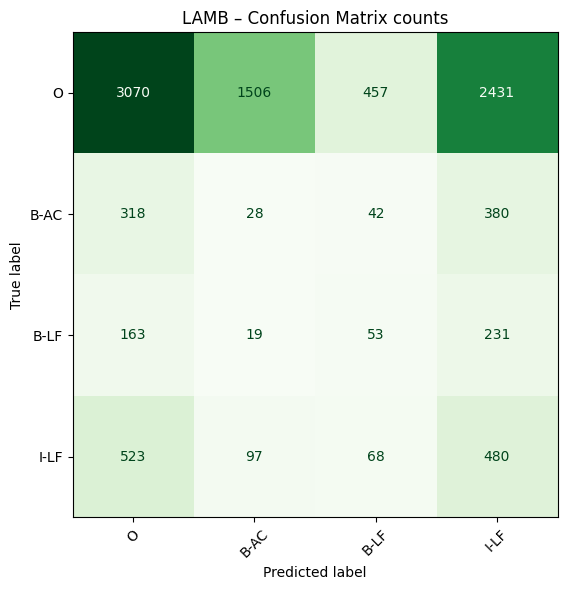

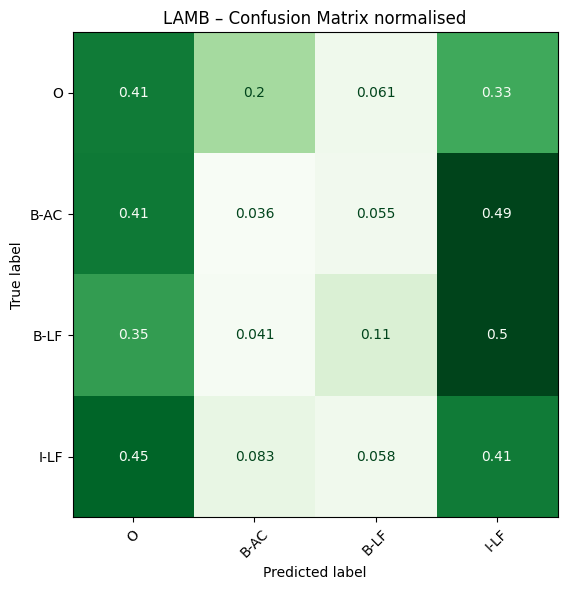


LION – confusion matrix



/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


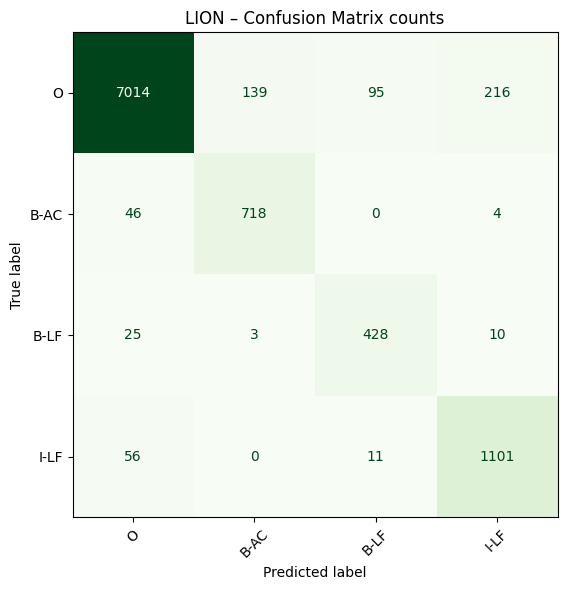

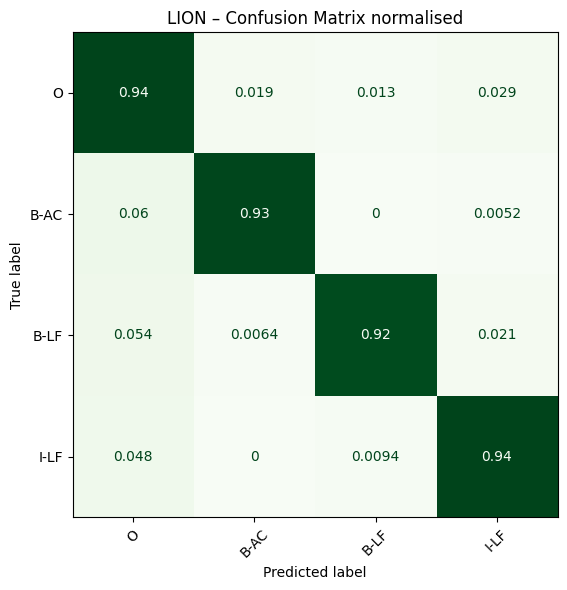

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for opt_name, tr in trainers.items():
    print(f"\n{opt_name.upper()} – confusion matrix\n")

    # predictions
    out       = tr.predict(test_ds)
    logits    = out.predictions
    label_ids = out.label_ids
    preds     = np.argmax(logits, axis=2)
    y_true, y_pred = [], []
    for seq_t, seq_p in zip(label_ids, preds):
        for t, p in zip(seq_t, seq_p):
            if t == -100:
                continue
            y_true.append(id2label[int(t)])
            y_pred.append(id2label[int(p)])

    # confusion matrix - count
    cm = confusion_matrix(y_true, y_pred, labels=label_list)
    disp = ConfusionMatrixDisplay(cm, display_labels=label_list)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Greens, colorbar=False)
    ax.set_title(f"{opt_name.upper()} – Confusion Matrix counts")
    plt.tight_layout()
    plt.show()

    # confusion matrix - notmalised
    cmn = confusion_matrix(y_true, y_pred, labels=label_list, normalize="true")
    dispn = ConfusionMatrixDisplay(cmn, display_labels=label_list)
    fig, ax = plt.subplots(figsize=(8, 6))
    dispn.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Greens, colorbar=False)
    ax.set_title(f"{opt_name.upper()} – Confusion Matrix normalised")
    plt.tight_layout()
    plt.show()



**Visualize optimizer performance**


Evaluating *untrained* RoBERTa on test split…



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Loss      : 1.4056
  F1        : 0.0088
  Precision : 0.0052
  Recall    : 0.0292



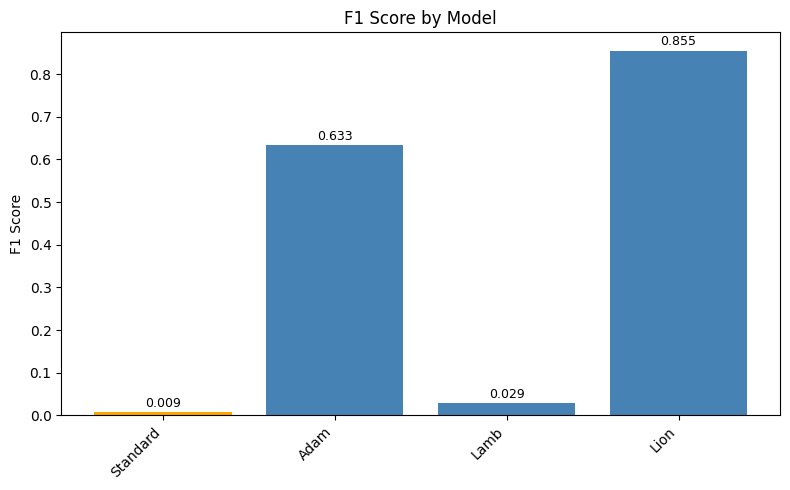

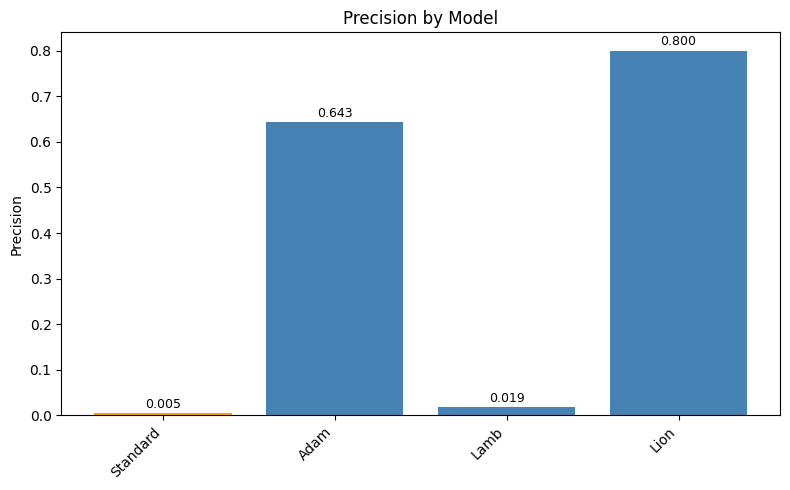

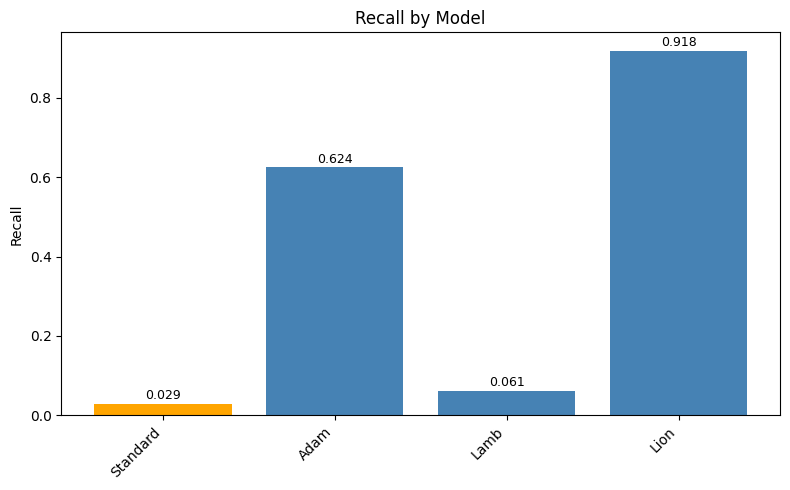

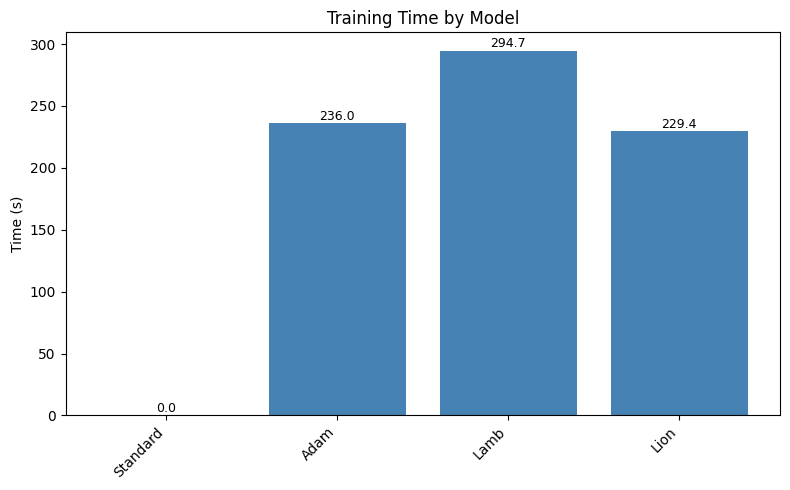

In [23]:

baseline_results = evaluate_standard_roberta(test_ds, split_name="test")

#  optimizer names
opt_names = list(results.keys())
models    = ["Standard"] + [name.capitalize() for name in opt_names]

# collecting each model’s test metrics
f1_scores  = [baseline_results["eval_f1"]]        + [results[o]["eval_f1"]        for o in opt_names]
precisions = [baseline_results["eval_precision"]] + [results[o]["eval_precision"] for o in opt_names]
recalls    = [baseline_results["eval_recall"]]    + [results[o]["eval_recall"]    for o in opt_names]
times      = [0.0]                                + [training_times[o]            for o in opt_names]

def plot_bar(values, title, ylabel):
    colors = ["orange"] + ["steelblue"] * len(opt_names)
    plt.figure(figsize=(8, 5))
    bars = plt.bar(models, values, color=colors)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha="right")
    for bar, val in zip(bars, values):
        fmt = f"{val:.1f}" if ylabel == "Time (s)" else f"{val:.3f}"
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + (0.005 if ylabel != "Time (s)" else 0.5),
            fmt,
            ha="center",
            va="bottom",
            fontsize=9
        )
    plt.tight_layout()
    plt.show()

# plot  for each metric
plot_bar(f1_scores,  "F1 Score by Model",      "F1 Score")
plot_bar(precisions, "Precision by Model",     "Precision")
plot_bar(recalls,    "Recall by Model",        "Recall")
plot_bar(times,      "Training Time by Model", "Time (s)")






**error analysing Lion model mispredictions**


In [24]:
lion_trainer = trainers["lion"]

# predictions
out = lion_trainer.predict(test_ds)
logits, label_ids = out.predictions, out.label_ids
preds = np.argmax(logits, axis=2)

all_tokens, all_true, all_pred = [], [], []
for example, true_seq, pred_seq in zip(test_ds, label_ids, preds):
    token_ids = example["input_ids"]
    words = tokenizer.convert_ids_to_tokens(token_ids)
    tl, pl = [], []
    for w, t, p in zip(words, true_seq, pred_seq):
        if t == -100:
            continue
        tl.append(id2label[int(t)])
        pl.append(id2label[int(p)])

    all_tokens.append(words)
    all_true.append(tl)
    all_pred.append(pl)

# show mis predictions
error_examples = [
    (tokens, true_tags, pred_tags)
    for tokens, true_tags, pred_tags in zip(all_tokens, all_true, all_pred)
    if any(t != p for t, p in zip(true_tags, pred_tags))
]

# inspect the first 10
for idx, (tokens, true_tags, pred_tags) in enumerate(error_examples[:10], 1):
    print(f"Example {idx}:")
    labeled_tokens = [
        tok for tok, t in zip(tokens, true_tags + ["X"]*(len(tokens)-len(true_tags)))
    ]
    print("Tokens:    ", labeled_tokens)
    print("Gold tags: ", true_tags)
    print("Pred tags: ", pred_tags)
    print("-"*40)


Example 1:
Tokens:     ['<s>', 'ĠWithin', 'Ġam', 'o', 'eb', 'ae', 'Ġand', 'Ġmac', 'roph', 'ages', 'Ġ,', 'ĠL', '.', 'Ġpneum', 'oph', 'ila', 'Ġrepl', 'icates', 'Ġwith', 'Ġa', 'Ġsimilar', 'Ġmechanism', 'Ġby', 'Ġforming', 'Ġa', 'Ġmembrane', 'Ġ-', 'Ġbound', 'Ġcompartment', 'Ġ,', 'Ġthe', 'ĠLegion', 'ella', 'Ġ-', 'Ġcontaining', 'Ġvac', 'u', 'ole', 'Ġ(', 'ĠLC', 'V', 'Ġ)', 'Ġ.', 'ĠFormation', 'Ġof', 'Ġthe', 'ĠLC', 'V', 'Ġis', 'Ġnot', 'Ġwell', 'Ġdefined', 'Ġ,', 'Ġbut', 'Ġrequires', 'Ġthat', 'ĠL', '.', 'Ġpneum', 'oph', 'ila', 'Ġinject', 's', 'Ġproteins', 'Ġinto', 'Ġthe', 'Ġhost', 'Ġcell', 'Ġvia', 'Ġthe', 'Ġintr', 'ace', 'llular', 'Ġmultiplication', 'Ġ(', 'ĠI', 'cm', ')/', 'def', 'ective', 'Ġorgan', 'elle', 'Ġtrafficking', 'Ġ(', 'ĠDot', 'Ġ)', 'Ġsecretion', 'Ġsystem', 'Ġ.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa

**Conclusion**

In this experiment we trained a standard RoBERTa and then fine‑tuned it on the PLOD‑CW‑25 NER dataset, comparing three optimisers, Adam, LAMB and Lion under identical hyper‑parameters (3 epochs, LR = 5 × 10⁻⁶, batch size = 16) using token‑level cross‑entropy (ignore_index = ‑100).

 **Baseline (untrained RoBERTa)**: F1 = 0.0729 (model predicts almost exclusively “O”).

Adam:
F1 ≈ 0.617493, precision ≈ 0.621847, recall ≈ 0.613200 , in ~91.6 s

LAMB:
F1 ≈ 0.038388 precision ≈ 0.023938, recall ≈ 0.096847 , in ~113s
(Collapsed to “O” predictions under these hyperparameters.)

Lion:
F1 ≈ 0.863649 precision ≈ 0.803081, recall ≈ 0.934097 —in ~88.5s


